<a href="https://colab.research.google.com/github/lawsonk16/Object-Detection/blob/main/FasterRcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train Model

<i> Note: These paths are not universal - they are relative and require the user to set up their own data directory. With Colab it is difficult to do otherwise. </i>


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Step 1: Make Relevant Imports
We have defined many custom scripts, so we need to add them to our system path

In [ ]:
! pip install terminaltables

import sys
paths = ['/content/drive/MyDrive/Colab Notebooks/scripts']

for p in paths:
    sys.path.append(p)

import os
import json
import shutil

from coco_utils.pytorch_coco_detect import *
from ensemble import *
from coco_utils.coco_help import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Step 2: Unzip Data, Set Data Paths and Create Data Loaders

In [ ]:
data_zip_path = '/content/drive/MyDrive/Colab Notebooks/Clean Datasets/DOTA/DOTA_512_25p.zip'
data_path = '/content/'

shutil.copy2(data_zip_path, data_path)

shutil.unpack_archive(data_zip_path.split('/')[-1])
os.remove(data_zip_path.split('/')[-1])

In [ ]:
# change the data tag to match your dataset, if applicable
data_tag = 'DOTA-512-25p'

train_ims = 'train/images/'
val_ims = 'val/images/'

train_anns = f'train/dota_25_train.json'
val_anns = f'val/dota_25_val.json'

make_cat_ids_match(train_anns, val_anns) 

In [ ]:
num_workers = 0
train_batch_size = 2
train_data_loader = make_train_loader(train_ims, train_anns, train_batch_size, num_workers)

num_workers = 0
val_batch_size = 1
val_data_loader = make_test_loader(val_ims, val_anns, val_batch_size, num_workers)

loading annotations into memory...
Done (t=0.28s)
creating index...
index created!
loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


### Part 3: Prepare the Model
 - Create a model name for experiments with these hyperparameters
   - If previous training has occurred, this will be the path where that info is stored
 - Load a model of the correct depth

In [ ]:
# Check the number of catgeories
with open(train_anns, 'r') as f:
    gt = json.load(f)

cats = gt['categories']

In [ ]:
### Modify these variables for your experiment ###
exp_folder = '/content/drive/MyDrive/Colab Notebooks/Experiments/Detection/'
data_name = 'DOTA'
data_split = '25p'

resnet_backbone = 50
num_classes = len(cats) + 1

optim = 'SGD'
lr = 0.0001
mom = 0.9
wd = 0.0005
pretrained = True

model_path = name_model(exp_folder, data_name, data_split, resnet_backbone, train_batch_size, num_classes, optim, lr, mom, wd, pretrained)
model_path

'/content/drive/MyDrive/Colab Notebooks/Experiments/Detection/DOTA/25p/resnet50fpn/classes_17_optim_SGD_lr_0p0001_mom_0p9_wd_0p0005_pretrained_True_batch_2/best_weights.pt'

### Part 4: Train the Model 
Set a few more hyperparameters, and display precision and recall on validation set at a frequency you set

In [ ]:
# Choose a total number of epochs to train with this configuration
num_epochs = 100

# Evaluation Criteria
start_eval_epoch = 5
eval_freq = 10
iou_nms = 0.7

# How often to save
save_freq = 10

# wrap up the data
data_loaders = [train_data_loader, val_data_loader]

# get the model
model = get_fasterrcnn(num_classes, pretrained, resnet_backbone)

losses = train_fasterrcnn(model, model_path, data_loaders, 
                                optim, lr, mom, wd, 
                                num_epochs, start_eval_epoch, eval_freq, iou_nms, save_freq)

Loading 100 epochs of training for fasterrcnn


## Part 5: Evaluate

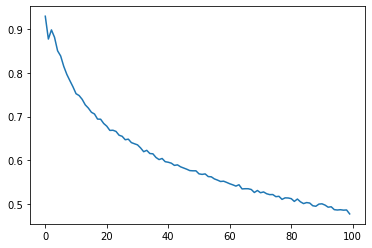

In [ ]:
plt.plot(range(0, len(losses)), losses)

In [ ]:
train_dt_path, val_dt_path = get_most_recent_dts(model_path)
train_dt_path, val_dt_path

conf_thresh = 0.2
iou_thresh = 0.3
nms_thresh = 0.6

class_names = get_class_names(val_anns)

# Detections
val_dts = yolo_coco_dts(val_anns, val_dt_path, conf_thresh)
val_dts = nms(val_dts, conf_thresh, nms_thresh)
val_gt = yolo_coco_gt(val_anns)

stats = evaluate_coco(val_dts, val_gt, class_names, iou_thresh)

Computing AP: 100%|██████████| 16/16 [00:00<00:00, 282.57it/s]

+-------+--------------------+---------+
| Index | Class name         | AP      |
+-------+--------------------+---------+
| 0     | small-vehicle      | 0.52641 |
| 1     | harbor             | 0.64759 |
| 2     | large-vehicle      | 0.66620 |
| 3     | ground-track-field | 0.33091 |
| 4     | soccer-ball-field  | 0.47453 |
| 5     | bridge             | 0.54149 |
| 6     | basketball-court   | 0.27823 |
| 7     | tennis-court       | 0.89665 |
| 8     | ship               | 0.84238 |
| 9     | roundabout         | 0.47121 |
| 10    | baseball-diamond   | 0.74126 |
| 11    | swimming-pool      | 0.59005 |
| 12    | plane              | 0.89937 |
| 13    | storage-tank       | 0.68398 |
| 14    | helicopter         | 0.53130 |
| 15    | container-crane    | 0.00000 |
+-------+--------------------+---------+
---- mAP 0.5700965880478113
---- Precision 0.35179259261609674
---- Recall 0.6557624218925364


In [ ]:
# Detections
val_dts = yolo_coco_dts(val_anns, val_dt_path, conf_thresh)
val_dts = nms(val_dts, conf_thresh, 0.5)
val_gt = yolo_coco_gt(val_anns)

stats = evaluate_coco(val_dts, val_gt, class_names, iou_thresh)

Computing AP: 100%|██████████| 16/16 [00:00<00:00, 297.85it/s]

+-------+--------------------+---------+
| Index | Class name         | AP      |
+-------+--------------------+---------+
| 0     | small-vehicle      | 0.52930 |
| 1     | harbor             | 0.64886 |
| 2     | large-vehicle      | 0.66554 |
| 3     | ground-track-field | 0.33091 |
| 4     | soccer-ball-field  | 0.47516 |
| 5     | bridge             | 0.54758 |
| 6     | basketball-court   | 0.27823 |
| 7     | tennis-court       | 0.89684 |
| 8     | ship               | 0.84195 |
| 9     | roundabout         | 0.47121 |
| 10    | baseball-diamond   | 0.74225 |
| 11    | swimming-pool      | 0.59035 |
| 12    | plane              | 0.89949 |
| 13    | storage-tank       | 0.68159 |
| 14    | helicopter         | 0.53750 |
| 15    | container-crane    | 0.00000 |
+-------+--------------------+---------+
---- mAP 0.5710472773138919
---- Precision 0.36163195295042516
---- Recall 0.6550839546070868


<Figure size 432x288 with 0 Axes>

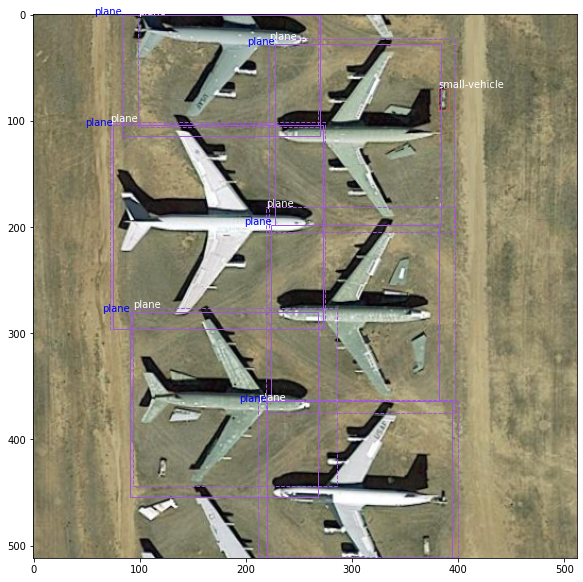

<Figure size 432x288 with 0 Axes>

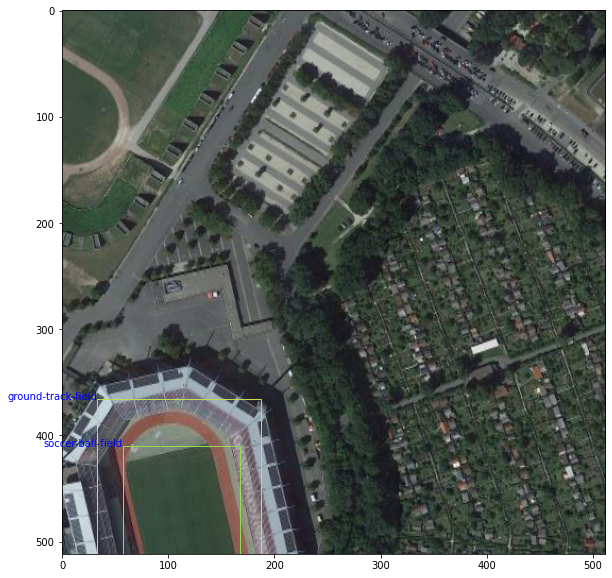

<Figure size 432x288 with 0 Axes>

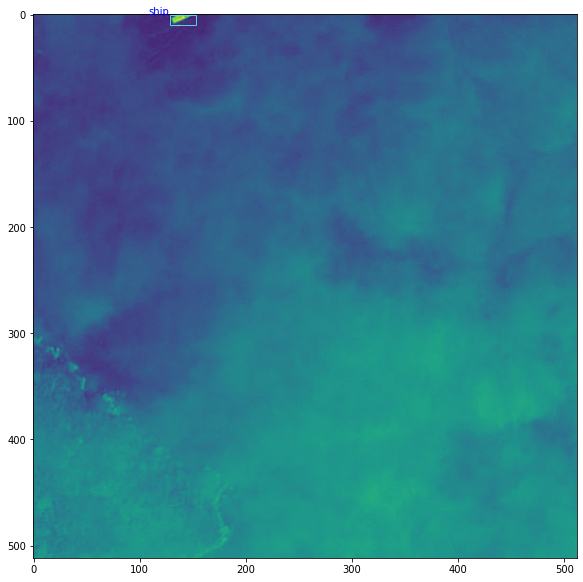

<Figure size 432x288 with 0 Axes>

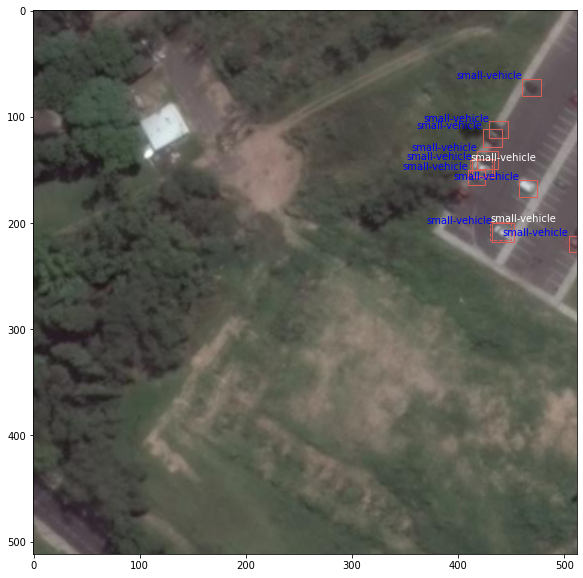

<Figure size 432x288 with 0 Axes>

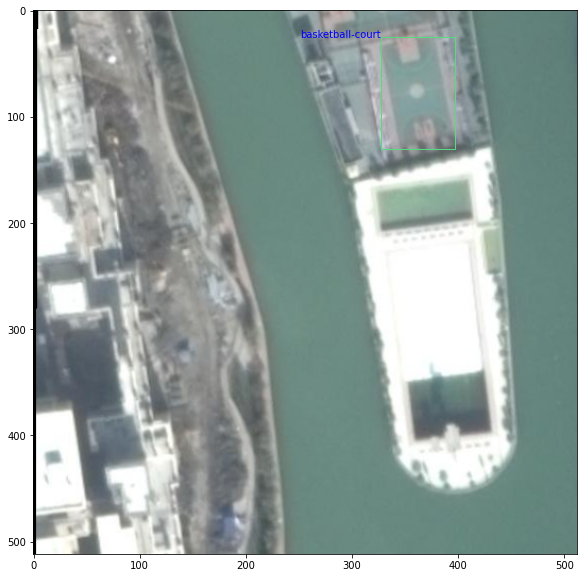

In [ ]:
# Get some examples - blue text/solid lines are the ground truth
display_random_gt_dt(5, val_anns, val_dt_path, val_ims, (10,10))